<a href="https://colab.research.google.com/github/harry-vaibhav-agarwal/Machine-Learning/blob/main/Diagnosis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy and Unzip Data and Labels

In [1]:
# Python library for copying files from My Drive
import shutil

In [2]:

# Ignore if running locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ignore if running locally
# Otherwise change `drive/My Drive/Colab Notebooks/Data/ISIC2018_Task3_Training_*.zip` to /path/to/data
shutil.copy2("/content/drive/MyDrive/Data/ISIC2018_Task3_Training_GroundTruth.zip", "./")
shutil.copy2("/content/drive/MyDrive/Data/Training_Input.zip", "./")

'./Training_Input.zip'

In [4]:
!unzip -q ISIC2018_Task3_Training_GroundTruth.zip

In [5]:
!unzip -q Training_Input.zip

## Attribution

In [6]:
print(open("ISIC2018_Task3_Training_GroundTruth/ATTRIBUTION.txt").read())

ISIC-2018 Challenge: Task 3: Training Ground Truth (HAM10000 Dataset: https://arxiv.org/abs/1803.10417 ) (c) by ViDIR Group, Department of Dermatology, Medical University of Vienna

ISIC-2018 Challenge: Task 3: Training Ground Truth (HAM10000 Dataset: https://arxiv.org/abs/1803.10417 ) is licensed under a
Creative Commons Attribution-NonCommercial 4.0 International License.

You should have received a copy of the license along with this
work. If not, see <http://creativecommons.org/licenses/by-nc/4.0/>.



## Make labels/data FAST.AI ready

In [7]:
import os
import math
import pandas as pd
import numpy as np

In [8]:
np.random.seed(42)

In [9]:
df = pd.read_csv("ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv",nrows=1000)

In [10]:
for col in df.columns:
  if col != "image":
    s = df[col].sum()
    c = df[col].count()
    print("Column: {}\t Count: {}\t Percentage: {}".format(col, s, round((s/c)*100, 2)))

Column: MEL	 Count: 91.0	 Percentage: 9.1
Column: NV	 Count: 685.0	 Percentage: 68.5
Column: BCC	 Count: 52.0	 Percentage: 5.2
Column: AKIEC	 Count: 36.0	 Percentage: 3.6
Column: BKL	 Count: 111.0	 Percentage: 11.1
Column: DF	 Count: 11.0	 Percentage: 1.1
Column: VASC	 Count: 14.0	 Percentage: 1.4


In [11]:
# Image classes are in individual columns
# Created a new column name `class` 
# which contains values from 0-6
df["class"] = df.drop("image", axis=1).apply(lambda x: x.to_numpy().argmax(), axis=1)

In [12]:
# What each value means in the `class` column
a = list(df.columns)
for i in ["image", "class"]:
  a.remove(i)
a = dict(zip(a, range(len(a))))
print(a)

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}


In [13]:
df.drop(a.keys(), axis=1, inplace=True)

In [14]:
df.to_csv("isic_labels.csv", index=False)

### Extract Validation Dataset

In [15]:
test_idx = []
for c in df["class"].unique():
    # get all the image names from a particular class
    temp = df[df['class'].apply(lambda x: True if x == c else False)]
    # extract 10% of images from each class
    test_idx += temp.sample(math.floor(temp.shape[0]/10)).index.to_list()

In [16]:
# create a test dataframe
test_df = df.iloc[test_idx].reset_index(drop=True)

In [17]:
# create a train dataframe
train_df = df.drop(labels=test_idx).reset_index(drop=True)

In [18]:
train_df.to_csv("isic_train_labels.csv", index=False)
test_df.to_csv("isic_test_labels.csv", index=False)

### Oversampling

In [19]:
df = pd.read_csv("isic_train_labels.csv")

In [20]:
# class NV has highest number of images
sum(df["class"] == 1)

617

In [21]:
classes = df["class"].unique()
max_val = 617

In [22]:
path = "Training_Input"
def cloning(img, count):
  """
  img: Image Name
  count: Number of times `img` needs to be copied.
  """
  images = []
  for i in range(count):
    ii = img+"_"+str(i)
    img_path = os.path.join(path, img+".jpg")
    ii_path = os.path.join(path, ii+".jpg")
    # Creating a copy of `img` in the file system
    shutil.copy(img_path, ii_path)
    images.append(ii)
  return images

In [23]:
# I know.. this method is pretty dumb(memory inefficient).
# If you know how to do it with data_block api(without creating multiple copies in file system).
# Please share with me.
images, labels = [], []
for c in classes:
    if c == 1:
        continue
    data = df[df["class"].apply(lambda x: True if x == c else False)]
    l = data.image.shape[0]
    rest = max_val - (math.floor(max_val/l)*l)
    ns = [j+1 if i < rest else j for i, j in enumerate([math.floor(max_val/l)]*l)]
    for i, n in zip(data.image.values, ns):
        images += cloning(i, n)
        labels += [c]*n

In [24]:
# `oversampled` do not contain any class `1` image
oversampled = pd.DataFrame({"image": images, "class": labels})

In [25]:
df_1 = df[df["class"].apply(lambda x: True if x == 1 else False)]

In [26]:
balanced = pd.concat([oversampled, df_1]).reset_index(drop=True) # New balanced dataset

In [27]:
# For data_block api to understand which image is for training
# and which one is for validation
balanced["is_valid"] = False
test_df["is_valid"] = True

In [28]:
balanced = pd.concat([balanced, test_df]).reset_index(drop=True)

In [ ]:
# balanced[-10:]

In [29]:
balanced.to_csv("isic_labels_balanced.csv", index=False)

## Start Coding FAST

In [30]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'
100  9127    0  9127    0     0  69671      0 --:--:-- --:--:-- --:--:-- 69671
(23) Failed writing body


In [31]:
from fastai.vision import *

In [32]:
# Copied from lesson3-planet.ipynb
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1., flip_vert=True)

In [33]:
src = (ImageList.from_csv("./", "isic_labels_balanced.csv", folder="Training_Input", suffix=".jpg")
                .split_from_df() # uses `is_valid` column
                .label_from_df())

After this, I did a bunch of training using various Resnet models and training sizes.

---


```
Recall(average="macro") == Balanced Accuracy
```

### Resnet 34 with size 224

In [34]:
data = (src.transform(tfms, size=224)
           .databunch()
           .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=Recall(average="macro"))
learn.fit_one_cycle(5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

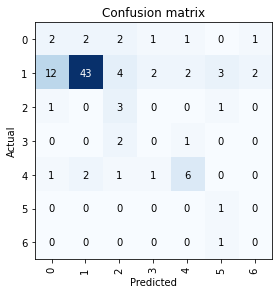

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [36]:
# After training every stage I copy it to my drive.
learn.save('stage1-sz224-rn34')
shutil.copy2("./models/stage1-sz224-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn34.pth'

In [39]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

KeyboardInterrupt: ignored

In [38]:
learn.save('stage2-sz224-rn34')
shutil.copy2("./models/stage2-sz224-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn34.pth'

### Resnet 34

#### Size 64

In [40]:
data = (src.transform(tfms, size=64)
           .databunch()
           .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [41]:
data

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

ImageDataBunch;

Train: LabelList (4319 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (98 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

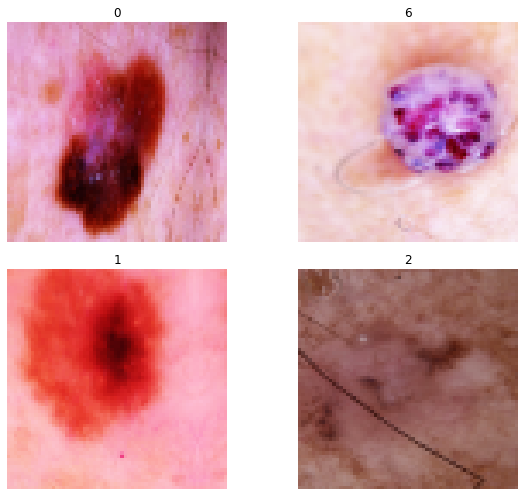

In [42]:
data.show_batch(rows=2, figsize=(9,7))

In [44]:
data.classes, data.c

([0, 1, 2, 3, 4, 5, 6], 7)

In [45]:
learn = cnn_learner(data, models.resnet34, metrics=Recall(average="macro"))

In [49]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,2.278107,1.734125,0.447717,01:37
1,1.761136,1.652822,0.589513,01:48
2,1.439261,1.207111,0.608166,01:51
3,1.256508,1.147084,0.430677,01:53
4,1.165745,1.157791,0.428576,01:53


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

In [50]:
learn.save('stage1-sz64-rn34')
shutil.copy2("./models/stage1-sz64-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz64-rn34.pth'

In [ ]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.863984,0.818419,0.677289,09:11
1,0.813371,0.819260,0.693993,08:48
2,0.744983,0.785273,0.701954,08:50
3,0.725196,0.753805,0.717991,08:54
4,0.721513,0.770385,0.706379,09:02


In [52]:
learn.save('stage2-sz64-rn34')
shutil.copy2("./models/stage2-sz64-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz64-rn34.pth'

#### Size 128

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data # Take the model(trained with size 64) and retrain on size 128
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [ ]:
learn.freeze()
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.745451,0.705414,0.723860,11:47
1,0.668169,0.635699,0.737007,11:36
2,0.609389,0.660066,0.765177,11:37
3,0.547385,0.609776,0.765725,11:49
4,0.534062,0.589395,0.766407,11:48


In [ ]:
learn.save('stage1-sz128-rn34')
shutil.copy2("./models/stage1-sz128-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz128-rn34.pth'

In [ ]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.506721,0.623814,0.771984,11:54
1,0.464688,0.560413,0.788222,11:53
2,0.454082,0.592337,0.790315,11:58


In [ ]:
learn.save('stage2-sz128-rn34')
shutil.copy2("./models/stage2-sz128-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz128-rn34.pth'

#### Size 256

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn.data = data # Take the model(trained with size 128) and retrain on size 256
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.535596,0.575985,0.805466,15:13
1,0.478631,0.495318,0.828277,15:21
2,0.413386,0.518744,0.843815,15:13
3,0.386791,0.461764,0.826640,15:02
4,0.368453,0.458687,0.836557,15:05


In [ ]:
learn.save('stage1-sz256-rn34')
shutil.copy2("./models/stage1-sz256-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz256-rn34.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.347334,0.480635,0.830765,15:36
1,0.304978,0.438051,0.826679,15:32
2,0.282736,0.434938,0.865638,15:28
3,0.255134,0.386405,0.856789,15:32
4,0.248768,0.383055,0.859372,15:31


In [ ]:
learn.save('stage2-sz256-rn34')
shutil.copy2("./models/stage2-sz256-rn34.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz256-rn34.pth'

### Resnet 50

#### Resnet 50 with Transformation

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

torch.Size([3, 224, 224])

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=Recall(average="macro"))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 24326111.97it/s]


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.872312,0.699592,0.696638,18:34
1,0.617363,0.681865,0.785294,18:35
2,0.480624,0.488268,0.792648,18:35
3,0.399762,0.528991,0.823713,18:31
4,0.394881,0.494366,0.828469,18:37


In [ ]:
learn.save('stage1-sz224-rn50')
shutil.copy2("./models/stage1-sz224-rn50.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn50.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.372787,0.505929,0.830523,19:26
1,0.337415,0.434628,0.840782,19:19
2,0.283363,0.405296,0.838716,19:32
3,0.253170,0.401649,0.841642,19:20
4,0.249348,0.414254,0.852529,19:22


In [ ]:
learn.save('stage2-sz224-rn50')
shutil.copy2("./models/stage2-sz224-rn50.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn50.pth'

#### Resnet 50 without Transformation

In [ ]:
# Result was already bad compared to other stages.
# Stopped it.
data = (src.transform(size=224)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=Recall(average="macro"))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.368151,0.740659,0.633112,16:11


KeyboardInterrupt: ignored

In [ ]:
learn.save('stage1-sz224-rn50-woT')
shutil.copy2("./models/stage1-sz224-rn50-woT.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

In [ ]:
learn.save('stage2-sz224-rn50-woT')
shutil.copy2("./models/stage2-sz224-rn50-woT.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

#### Resnet 50 without ImageNet Stats

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch().normalize())

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=Recall(average="macro"))
learn.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 38893584.93it/s]


epoch,train_loss,valid_loss,recall,time
0,0.907643,0.891449,0.682667,17:48
1,0.633818,0.614042,0.762963,17:35
2,0.490199,0.542620,0.788866,17:32
3,0.405198,0.519854,0.791490,17:36
4,0.395590,0.484124,0.813352,17:43


In [ ]:
learn.save('stage1-sz224-rn50-woISTATS')
shutil.copy2("./models/stage1-sz224-rn50-woISTATS.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

In [ ]:
# Result was already bad compared to other stages.
# Stopped it.
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.360126,0.462187,0.811870,18:25
1,0.322212,0.458139,0.818272,18:27
2,0.292973,0.428908,0.824923,18:26


KeyboardInterrupt: ignored

In [ ]:
learn.save('stage2-sz224-rn50-woISTATS')
shutil.copy2("./models/stage2-sz224-rn50-woISTATS.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

### Resnet 101

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet101, metrics=Recall(average="macro"))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.843094,0.717341,0.763869,19:01
1,0.568740,0.566178,0.794980,18:55
2,0.427227,0.532300,0.833284,19:04
3,0.354840,0.453607,0.822989,19:01
4,0.339358,0.438968,0.855869,18:59


In [ ]:
learn.save('stage1-sz224-rn101')
shutil.copy2("./models/stage1-sz224-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn101.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.313122,0.425760,0.863088,20:45
1,0.257644,0.397432,0.873868,20:46
2,0.226868,0.357821,0.866362,20:31
3,0.204757,0.325785,0.879824,20:29
4,0.191248,0.350226,0.883955,20:23


In [ ]:
learn.save('stage2-sz224-rn101')
shutil.copy2("./models/stage2-sz224-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn101.pth'

### Resnet 152

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=Recall(average="macro"))
learn.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:10, 22546052.11it/s]


epoch,train_loss,valid_loss,recall,time
0,0.785708,0.709159,0.739327,21:32
1,0.519026,0.645384,0.815162,21:44
2,0.409894,0.487464,0.832022,21:45
3,0.328334,0.452459,0.847651,22:01
4,0.307490,0.468136,0.849233,21:59


In [ ]:
learn.save('stage1-sz224-rn152')
shutil.copy2("./models/stage1-sz224-rn152.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn152.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.286909,0.395956,0.855177,23:51
1,0.256752,0.413372,0.854086,23:14
2,0.214330,0.350319,0.857564,22:53
3,0.187390,0.351069,0.856926,22:40
4,0.169617,0.335280,0.848321,23:13


In [ ]:
learn.save('stage2-sz224-rn152')
shutil.copy2("./models/stage2-sz224-rn152.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn152.pth'

###  Focal Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# https://github.com/Hsuxu/Loss_ToolBox-PyTorch/blob/master/FocalLoss/FocalLoss.py
class FocalLoss(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param num_class:
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param smooth: (float,double) smooth value when cross entropy
    :param balance_index: (int) balance class index, should be specific when alpha is float
    :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
    """

    def __init__(self, num_class, alpha=None, gamma=2, balance_index=-1, smooth=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.num_class = num_class
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.size_average = size_average

        if self.alpha is None:
            self.alpha = torch.ones(self.num_class, 1)
        elif isinstance(self.alpha, (list, np.ndarray)):
            assert len(self.alpha) == self.num_class
            self.alpha = torch.FloatTensor(alpha).view(self.num_class, 1)
            self.alpha = self.alpha / self.alpha.sum()
        elif isinstance(self.alpha, float):
            alpha = torch.ones(self.num_class, 1)
            alpha = alpha * (1 - self.alpha)
            alpha[balance_index] = self.alpha
            self.alpha = alpha
        else:
            raise TypeError('Not support alpha type')

        if self.smooth is not None:
            if self.smooth < 0 or self.smooth > 1.0:
                raise ValueError('smooth value should be in [0,1]')

    def forward(self, input, target):
        logit = F.softmax(input, dim=1)

        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.permute(0, 2, 1).contiguous()
            logit = logit.view(-1, logit.size(-1))
        target = target.view(-1, 1)

        # N = input.size(0)
        # alpha = torch.ones(N, self.num_class)
        # alpha = alpha * (1 - self.alpha)
        # alpha = alpha.scatter_(1, target.long(), self.alpha)
        epsilon = 1e-10
        alpha = self.alpha
        if alpha.device != input.device:
            alpha = alpha.to(input.device)

        idx = target.cpu().long()

        one_hot_key = torch.FloatTensor(target.size(0), self.num_class).zero_()
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        if one_hot_key.device != logit.device:
            one_hot_key = one_hot_key.to(logit.device)

        if self.smooth:
            one_hot_key = torch.clamp(
                one_hot_key, self.smooth, 1.0 - self.smooth)
        pt = (one_hot_key * logit).sum(1) + epsilon
        logpt = pt.log()

        gamma = self.gamma

        alpha = alpha[idx]
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

### Resnet 101 with Focal Loss

In [ ]:
FL = FocalLoss(num_class=7, alpha=0.25, gamma=2.0, balance_index=2)

In [ ]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet101, metrics=Recall(average="macro"), loss_func=FL)
learn.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:06, 27163988.73it/s]


epoch,train_loss,valid_loss,recall,time
0,0.335531,0.274163,0.729967,19:58
1,0.207919,0.186859,0.782605,20:01
2,0.155136,0.167362,0.833713,20:00
3,0.113781,0.142307,0.832480,19:55
4,0.108782,0.148174,0.840843,20:10


In [ ]:
learn.save('stage1-sz224-rn101-fLoss')
shutil.copy2("./models/stage1-sz224-rn101-fLoss.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz224-rn101-fLoss.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.094407,0.135128,0.837812,21:32
1,0.087238,0.120423,0.872192,21:24
2,0.066917,0.108963,0.868991,21:22
3,0.058729,0.101714,0.864691,21:28
4,0.058357,0.103694,0.874223,21:31


In [ ]:
learn.save('stage2-sz224-rn101-fLoss')
shutil.copy2("./models/stage2-sz224-rn101-fLoss.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz224-rn101-fLoss.pth'

### Resnet 101 with various sizes

#### Size 64

In [ ]:
data = (src.transform(tfms, size=64)
           .databunch()
           .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (42245 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (998 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,1,1,1
Path: .;

Test: None

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

In [ ]:
learn = cnn_learner(data, models.resnet101, metrics=Recall(average="macro"))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 69422975.62it/s]


In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('stage1-sz64-rn101')
shutil.copy2("./models/stage1-sz64-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz64-rn101.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.671971,0.697834,0.734063,09:38
1,0.633835,0.649670,0.736626,09:30
2,0.557029,0.615166,0.746225,09:40
3,0.508771,0.602678,0.746066,09:37
4,0.507367,0.604513,0.756266,09:39


In [ ]:
learn.save('stage2-sz64-rn101')
shutil.copy2("./models/stage2-sz64-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz64-rn101.pth'

#### Size 128

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

'./models/stage1-sz128-rn101.pth'

In [ ]:
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.529179,0.529846,0.772806,12:31
1,0.453468,0.546258,0.808928,12:23
2,0.379408,0.537282,0.808096,12:16
3,0.331285,0.467886,0.831906,12:26
4,0.319030,0.480315,0.832879,12:22


In [ ]:
learn.save('stage1-sz128-rn101')
shutil.copy2("./models/stage1-sz128-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.315274,0.483389,0.825892,13:24
1,0.278202,0.468720,0.831486,12:31
2,0.256792,0.456374,0.846680,12:32


In [ ]:
learn.save('stage2-sz128-rn101')
shutil.copy2("./models/stage2-sz128-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

#### Size 256

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [ ]:
learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.317201,0.453863,0.838456,17:04
1,0.268208,0.456758,0.854131,17:00
2,0.228409,0.910646,0.859474,17:04
3,0.203442,0.640575,0.878315,16:47
4,0.183151,0.610423,0.876823,16:38


In [ ]:
learn.save('stage1-sz256-rn101')
shutil.copy2("./models/stage1-sz256-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage1-sz256-rn101.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,recall,time
0,0.183502,0.816586,0.852542,18:22
1,0.163206,0.384709,0.874428,18:27
2,0.144963,0.330809,0.885069,18:23
3,0.115770,0.326646,0.868896,18:34
4,0.108229,0.318335,0.885232,18:42


In [ ]:
learn.save('stage2-sz256-rn101')
shutil.copy2("./models/stage2-sz256-rn101.pth", "./drive/My Drive/Colab Notebooks/Data/models/")

'./drive/My Drive/Colab Notebooks/Data/models/stage2-sz256-rn101.pth'

In [ ]:
learn.validate()

[0.3183352, tensor(0.8852)]

## To Do

1.   Focal loss + Resnet101 + various train sizes
2.   Resnet152 + various train sizes
3.   Focal loss + Resnet152 + various train sizes